<a href="https://colab.research.google.com/github/NaziaHasanDana/DeepLearning/blob/main/LeNet_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

# Path to your zip file
zip_path = '/content/covid-19_healthy.zip'

# Directory where you want to extract the files
extract_dir = '/content/covid-19_healthy'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to: {extract_dir}")


Dataset extracted to: /content/covid-19_healthy


In [2]:
# List the files in the extracted directory
!ls /content/covid-19_healthy


covid-19  healthy  pneumonia


In [3]:
# Libraries
import os
import pathlib

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

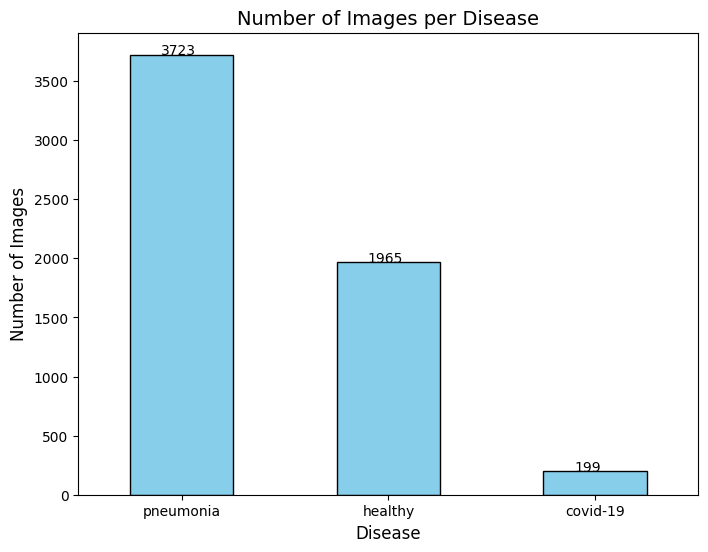

Training set size = 4709, Validation set size = 589, Test set size = 589


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Path to the unzipped dataset in Google Colab
data_dir= "/content/covid-19_healthy"


# Initialize empty lists for storing image file paths and their corresponding labels
image_paths = []
labels = []

# Traverse the directory structure to populate image_paths and labels
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):  # Ensure it's a directory
        for file_name in os.listdir(label_dir):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                image_paths.append(os.path.join(label_dir, file_name))
                labels.append(label)

# Create a Pandas DataFrame with the image file paths and labels
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Check if the DataFrame is empty
if data_frame.empty:
    print("Data frame is empty. Please check your data directory and file structure.")
else:
    # Visualize the number of images per class
    label_counts = data_frame['labels'].value_counts()
    ax = label_counts.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')

    plt.xlabel('Disease', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Number of Images per Disease', fontsize=14)
    plt.xticks(rotation=0, fontsize=10)

    # Annotate bar chart with counts
    for i in ax.patches:
        ax.text(i.get_x() + 0.15, i.get_height() + 0.5, str(i.get_height()), fontsize=10, color='black')

    plt.show()

    # Split the data into training (80%), validation (10%), and test sets (10%)
    strat = data_frame['labels']
    train_df, temp_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Further split temp_df equally for validation and test sets (each 10%)
    strat_temp = temp_df['labels']
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat_temp)

    # Print the sizes of each split
    print(f"Training set size = {len(train_df)}, Validation set size = {len(valid_df)}, Test set size = {len(test_df)}")

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Determine the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length that are less than or equal to 80
factors = [n for n in range(1, test_length + 1) if test_length % n == 0 and test_length // n <= 80]

# Select the largest factor as the test batch size
test_batch_size = max(factors) if factors else test_length  # Default to test_length if no factors found

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged (identity function for no augmentation)
def identity(img):
    return img

# Create image data generators for the training, validation, and test datasets
train_augmentor = ImageDataGenerator(preprocessing_function=identity, horizontal_flip=True)
test_augmentor = ImageDataGenerator(preprocessing_function=identity)

# Flow from dataframe for training set
train_gen = train_augmentor.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Since we have multiple classes (covid, healthy, pneumonia)
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

# Flow from dataframe for validation set
valid_gen = test_augmentor.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Same as training (multi-class)
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

# Flow from dataframe for test set
test_gen = test_augmentor.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Test set should also be multi-class
    color_mode='rgb',
    shuffle=False,  # No shuffling for test set to maintain order
    batch_size=test_batch_size
)

# Print the computed test steps for debugging
print(f"Test Steps per Epoch: {test_steps}")


Found 4709 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Test Steps per Epoch: 1


In [6]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)

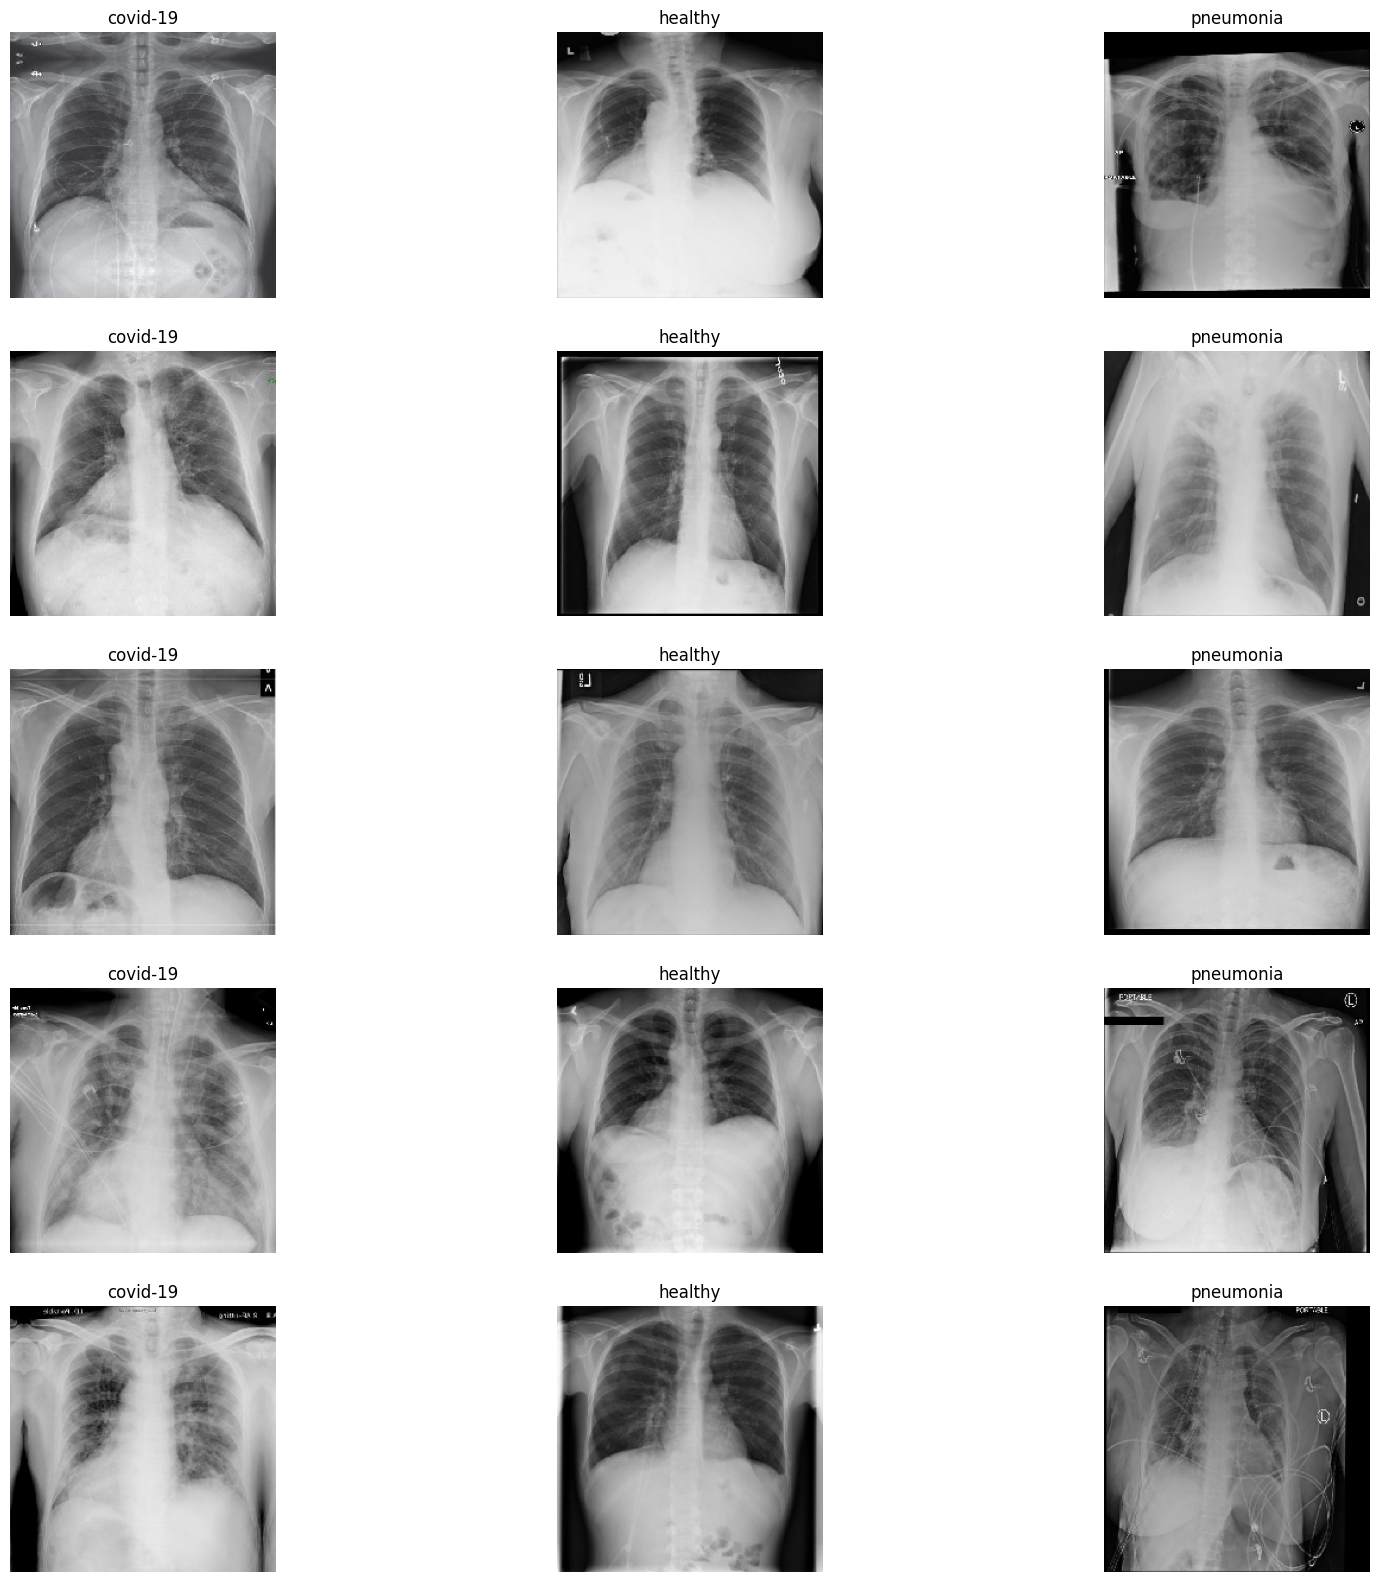

In [7]:

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Set parameters
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)

# Improved LeNet Model
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),  # Dropout to reduce overfitting
    Dense(num_classes, activation='softmax')
])

# Compile model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model for 20 epochs
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[model_checkpoint],
    verbose=1  # Show training progress
)

# Save the final model
model.save('final_model.keras')

# Load the best model (if needed)
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)

# Print test accuracy
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6564 - loss: 1.1727
Epoch 1: val_loss improved from inf to 0.61974, saving model to best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 103s 338ms/step - accuracy: 0.6564 - loss: 1.1717 - val_accuracy: 0.7317 - val_loss: 0.6197
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7509 - loss: 0.5651
Epoch 2: val_loss improved from 0.61974 to 0.58459, saving model to best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 187ms/step - accuracy: 0.7509 - loss: 0.5652 - val_accuracy: 0.7402 - val_loss: 0.5846
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7752 - loss: 0.5294
Epoch 3: val_loss did not improve from 0.58459
295/295 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.7751 - loss: 0.5294 - val_accuracy: 0.7572 - val_loss: 0.5895
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8064 - loss: 0.4631
Epoch 4: val_loss did not improve from 0.58459
295/295 ━━━━━━━━━━━━━━━━━━━━ 21s

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 699, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 750, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 824, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 785, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-25-618162c4642f>", line 59, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 484, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.6 = (f32[589,64,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[589,3,224,224]{3,2,1,0} %bitcast.442, f32[64,3,3,3]{3,2,1,0} %bitcast.444, f32[64]{0} %arg3.4), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_5_1/conv2d_10_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 7448015872 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_393003]

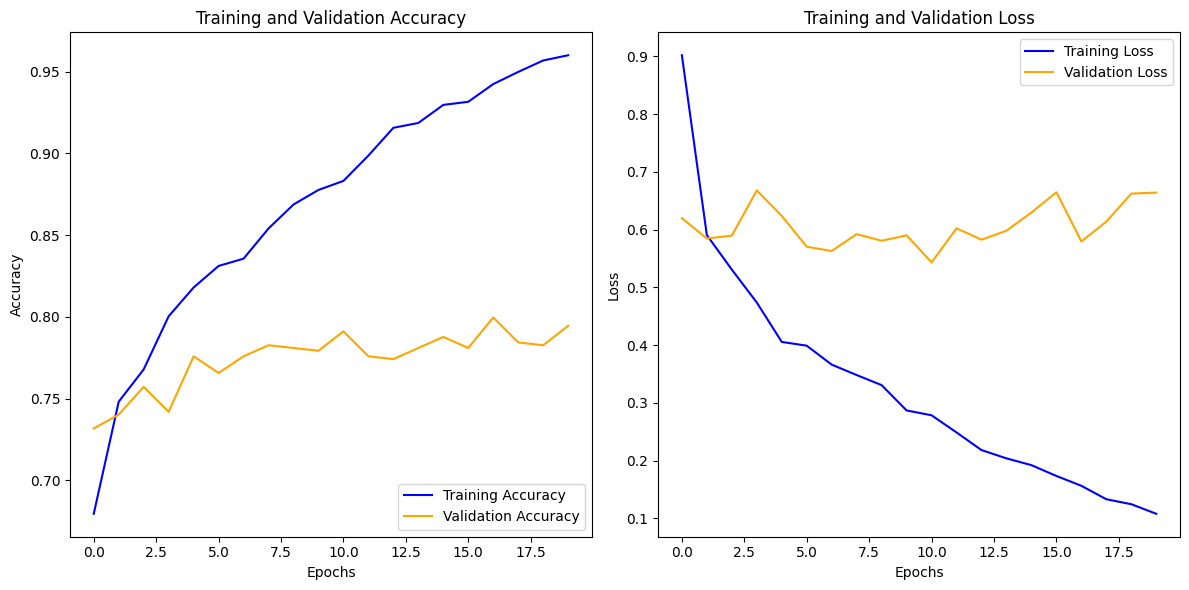

In [26]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the range of epochs
epochs_range = range(len(acc))  # Adjusts to the number of completed epochs

# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, first plot)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')  # Position the legend
plt.title('Training and Validation Accuracy')  # Title for the accuracy plot
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Accuracy')  # Label for y-axis

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, second plot)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')  # Position the legend
plt.title('Training and Validation Loss')  # Title for the loss plot
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis

# Show the plots
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


In [13]:
from tensorflow.keras.utils import plot_model

# Save the model to a file
model.save('MyModel_Saved.keras')  # Save in .keras format as recommended

# Visualize the model architecture and save it as an image
plot_model(
    model,
    to_file='model_architecture.png',  # File name for saving the architecture
    show_shapes=True,  # Display the shapes of input and output tensors
    show_layer_names=True  # Display the names of layers
)


KeyboardInterrupt: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


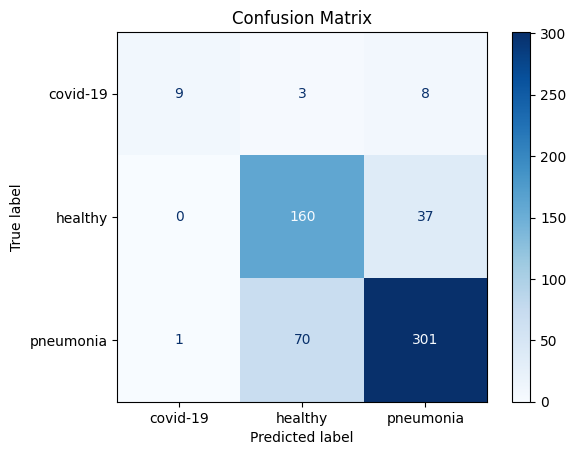

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have test data and corresponding labels
# Replace `test_gen` with your actual test data generator or dataset
test_images, test_labels = next(iter(test_gen))  # If using a generator

# Predict the classes for the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = np.argmax(test_labels, axis=1)       # Convert one-hot labels to class indices

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Replace class_names with your actual class labels
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


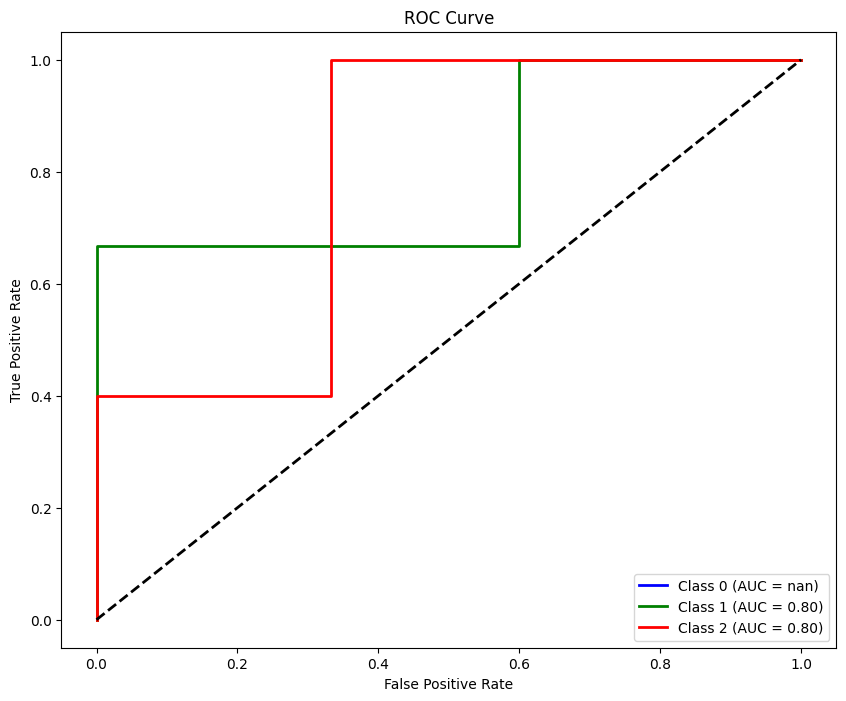

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have test data and corresponding labels
# Replace `test_gen` with your actual test data generator or dataset
test_images, test_labels = next(iter(test_gen))  # Extract test data from generator

# Predict probabilities for the test set
predictions = model.predict(test_images)

# If your labels are not already one-hot encoded, use `label_binarize`
# true_classes = label_binarize(test_labels, classes=[0, 1, 2])  # Modify classes as per your dataset
true_classes = test_labels  # If already one-hot encoded

# Number of classes
n_classes = true_classes.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']  # Adjust colors as per the number of classes
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [28]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Clear GPU memory before evaluation
K.clear_session()
gc.collect()

# Enable mixed precision training to reduce memory usage
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Load the best model
best_model = load_model('best_model.keras')

# Set a smaller test batch size to reduce memory usage
test_batch_size = 8  # Reduce batch size to avoid OOM error

# Create test data generator with reduced batch size
test_augmentor = ImageDataGenerator()
test_gen = test_augmentor.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),  # Reduce to (128, 128) if needed
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Limit GPU memory growth to prevent crashes
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Evaluate model on CPU if GPU still crashes
try:
    test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
except tf.errors.ResourceExhaustedError:
    print("Running on CPU due to GPU memory issue...")
    with tf.device('/CPU:0'):
        test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)

# Print test accuracy
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Found 589 validated image filenames belonging to 3 classes.
Physical devices cannot be modified after being initialized
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8128 - loss: 0.5557
Test Accuracy: 79.46%
